In [ ]:
%tensorflow_version 2.x

In [ ]:
!pip install pmdarima

In [ ]:
import pandas as pd 
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import requests
from io import StringIO
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import cufflinks as cf
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy import stats
import seaborn as sns
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [ ]:
import math

In [ ]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount
=True)

Mounted at /content/drive


In [ ]:
cd drive/

/content/drive


In [ ]:
pwd

'/content/drive'

In [ ]:
cd My  Drive


/content/drive/My Drive


In [ ]:
cd Major_Project/src/

/content/drive/My Drive/Major_Project/src


In [ ]:
df = pd.read_csv('sensor1_pp.csv',index_col = 0)
df

,ax(g),ay(g),az(g),wx(deg/s),wy(deg/s),wz(deg/s),AngleX(deg),AngleY(deg),AngleZ(deg),T(°),hx,hy,hz
ChipTime,,,,,,,,,,,,,
2020-02-18 15:40:20.960,-0.1851,0.1094,0.9927,-5.7373,-8.0566,5.1880,7.3663,11.4148,2.2852,18.11,929,-1405,27
2020-02-18 15:40:21.160,-0.1533,0.0942,1.0044,-6.1646,9.5215,0.2441,6.3062,10.0964,1.7084,18.15,924,-1399,47
2020-02-18 15:40:21.360,-0.1455,0.0859,1.0083,2.4414,1.5259,-1.0986,5.9656,9.5142,1.9391,18.14,896,-1369,51
2020-02-18 15:40:21.560,-0.1299,0.1064,1.0044,3.2959,-5.0659,9.2163,6.7072,8.4705,3.7573,18.14,931,-1369,49
2020-02-18 15:40:21.760,-0.1230,0.0986,1.0044,-4.5166,-6.5918,2.6245,6.3336,7.5751,4.5593,18.14,1012,-1426,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-28 11:41:17.960,0.6367,0.0605,0.7896,-1.0376,5.6763,0.0000,5.7404,-38.7103,11.8597,27.88,1316,1046,-1571
2020-02-28 11:41:18.160,0.6279,0.0527,0.8018,2.5024,11.9629,-0.1831,5.4602,-37.2107,12.8046,27.94,602,2811,-451
2020-02-28 11:41:18.360,0.5835,0.0669,0.8198,5.3711,10.3149,0.6714,5.7458,-35.1508,13.6011,27.88,1382,1107,-1501


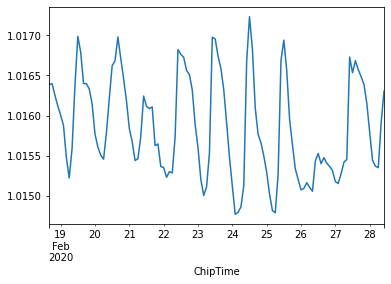

In [ ]:
#@title
df.index = pd.to_datetime(df.index)
az_data = df['az(g)'].resample('2H').mean() 
# az_data_rs = df['az(g)'].resample('1min').mean() 
az_data = az_data['2020-02-18':]
az_data = az_data[az_data.values > 1.014]
az_data.plot()

# **ARIMA**

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log 
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=(15,6)

**Stationarity Test**

In [ ]:
def stationarity_check(timeseries):
  # Rolling statistics
  rolling_mean = timeseries.rolling(30,1).mean()
  rolling_std = timeseries.rolling(30,1).std()

  #Plot rolling statistics
  original = go.Scatter(x=timeseries.index,y=timeseries.values)
  mean = go.Scatter(x=rolling_mean.index,y=rolling_mean.values, line=dict(color='chartreuse'))
  std = go.Scatter(x=rolling_std.index,y=rolling_std.values, line=dict(color='black'))

  figx = go.Figure()
  figx.add_trace(original)
  figx.add_trace(mean)
  figx.show()
 
  return original,mean,std
  

In [ ]:
def Dickey_Fuller_test(timeseries):
  print('Dickey Fuller Test:')
  di_fu_test = adfuller(timeseries,autolag='AIC')
  df_results = pd.Series(di_fu_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in di_fu_test[4].items():
        df_results['Critical Value (%s)'%key] = value
  print (df_results)

In [ ]:
# original,mean,std = stationarity_check(az_data)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
az_data_values = np.reshape(az_data.values, (len(az_data),1))
az_data_scaled = scaler.fit_transform(az_data_values)

In [ ]:
Dickey_Fuller_test(az_data_scaled)

Dickey Fuller Test:
Test Statistic                  -2.501971
p-value                          0.114996
#Lags Used                      12.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


In [ ]:
#@title
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm

In [ ]:
#@title

def acf_pacf(data,lags_):
  fig = plt.figure(figsize=(12,8))
  ax1 = fig.add_subplot(211)
  fig = sm.graphics.tsa.plot_acf(data, lags=lags_, ax=ax1) # 
  ax2 = fig.add_subplot(212)
  fig = sm.graphics.tsa.plot_pacf(data, lags=lags_, ax=ax2)# , lags=40

In [ ]:
az_scaled_df = pd.DataFrame(az_data_scaled)
az_diff = az_scaled_df.diff()
az_diff = az_diff.dropna()
Dickey_Fuller_test(az_diff)
# az_diff.plot()

Dickey Fuller Test:
Test Statistic                  -3.430914
p-value                          0.009949
#Lags Used                      12.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64


In [ ]:
# acf_pacf(az_data_scaled,40)
# acf_pacf(az_diff,40)


In [ ]:
train_size = np.int(len(az_data_scaled) * 0.6)
test_size = len(az_data_scaled) - train_size


train = az_data_scaled[0:train_size]
test = az_data_scaled[train_size:]

**p<0.05 ----> 95% confidence interval-------> time series is stationary**

**AUTO ARIMA**

In [ ]:
from pmdarima import auto_arima

from statsmodels.tsa.arima_model import ARIMA

**Working Model**

In [ ]:
az_data_fit = auto_arima(az_data_scaled,trace=True,suppress_warnings=True,error_action='ignore')


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=179.354, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=338.869, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=220.092, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=242.204, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=336.869, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=187.709, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=177.942, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=194.233, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=178.581, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=179.453, Time=0.25 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=178.791, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=181.502, Time=0.33 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=175.952, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=192.254, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=176.5

In [ ]:
def ARIMA_model(data,order_):
  model_ar=ARIMA(data,order=order_)
  model_ar= model_ar.fit()
  model_ar.summary()

  plt.plot(data)
  plt.plot(model_ar.fittedvalues, color = 'red')

  return model_ar

In [ ]:
# model_301 = ARIMA_model(train,(2,0,1))
# model_301.summary()

In [ ]:
# model_201 = ARIMA_model(az_data_scaled,(2,0,1))
# model_201.summary()

In [ ]:
# model_211 = ARIMA_model(train,(2,1,1))
# model_211.summary()

In [ ]:
# az_data_fit_new = auto_arima(az_data_scaled,trace=True,d=0,suppress_warnings=True,error_action='ignore')

**Seasonal Model**

In [ ]:
stepwise_fit = auto_arima(az_data_scaled, start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = 1, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.11 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=139.061, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=129.693, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=139.102, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=130.193, Time=0.48 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.01 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.43 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=130.401, Time=0.10 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=130.364, Time=0.23 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=131.381, Time=0.33 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=129.383, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=138.972, Time=0.05 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=129.948, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  118
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                 -61.691
Date:                             Thu, 15 Apr 2021   AIC                            129.383
Time:                                     14:59:53   BIC                            137.345
Sample:                                          0   HQIC                           132.609
                                             - 118                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1755      0.094      1.859      0.063      -0.010       0.361
ar.S.L12      -0.3609      0.083     -4.344      0.000      -0.524      -0.198
sigma2         0.1865      0.020      9.280      0.000       0.147       0.226
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                13.35
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.77   Skew:                            -0.16
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(train,  
                order = (0, 1, 1),  
                seasonal_order =(1, 1, 0, 12)) 
  
s_model = model.fit() 
s_model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   70
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                 -23.391
Date:                             Thu, 15 Apr 2021   AIC                             52.783
Time:                                     15:00:43   BIC                             58.912
Sample:                                          0   HQIC                            55.165
                                              - 70                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1038      0.144      0.721      0.471      -0.178       0.386
ar.S.L12      -0.1202      0.140     -0.862      0.389      -0.394       0.153
sigma2         0.1326      0.022      5.943      0.000       0.089       0.176
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.75
Prob(Q):                              0.98   Prob(JB):                         0.06
Heteroskedasticity (H):               0.57   Skew:                             0.67
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Model Evaluation Using MSE**

In [ ]:
def ARIMA_error(train_,test_,model):
  start = len(train_) 
  end = len(train_) + len(test_) - 1
  
# Predictions for one-year against the test set 
  predictions = model.predict(start, end, 
                             typ = 'levels')
  
# plot predictions and actual values 

  fig,ax = plt.subplots()
  ax.plot(test, '-b', label = 'actual')
  ax.plot(predictions, '-r', label = 'forecast')
  leg = ax.legend()

  return mean_squared_error(predictions,test)

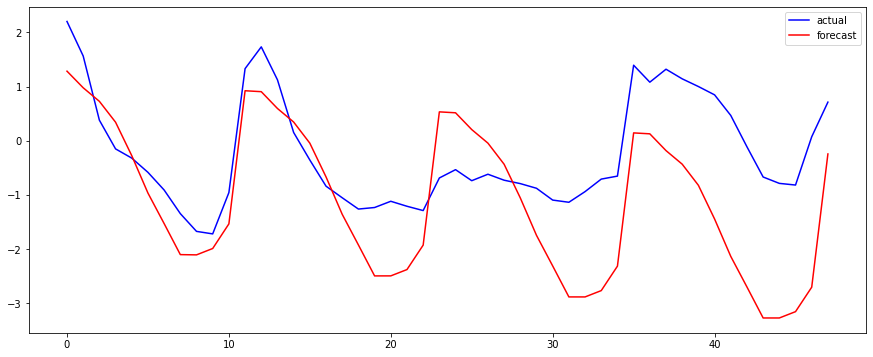

In [ ]:
# arima_301_mse = ARIMA_error(train,test,model_301)
# arima_211_mse = ARIMA_error(train,test,model_211)

sarima_mse = ARIMA_error(train,test,s_model)

# print(arima_301_mse, arima_211_mse)


In [ ]:
sarima_mse

1.807732775209093

**Out of Sample Forecast**

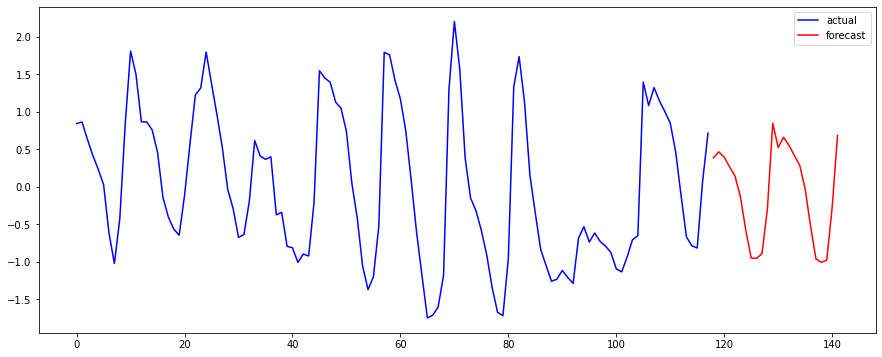

In [ ]:

# Train the model on the full dataset 
model = model = SARIMAX(az_data_scaled,  
                        order = (0, 1, 1),  
                        seasonal_order =(1, 1, 0, 12)) 
result = model.fit() 
  
# Forecast for the next 2 days 
forecast = result.predict(start = len(az_data_scaled),  
                          end = (len(az_data_scaled)-1) + 2 * 12,  
                          typ = 'levels')
  
# Plot the forecast values 
start = len(az_data_scaled)
end = (len(az_data_scaled)-1) + 2 * 12

x_range = np.arange(start,end+1)

fig,ax = plt.subplots()
ax.plot(az_data_scaled, '-b', label = 'past')
ax.plot(x_range,forecast, '-r', label = 'future')

leg = ax.legend()

**Evaluation**

In [ ]:
model301_MSE = (mean_squared_error(model_301.fittedvalues, az_data_scaled))
model301_rmse = math.sqrt(model301_MSE)
model301_rmse

0.24847191856588027

In [ ]:
model211_MSE = (mean_squared_error(model_211.fittedvalues, az_data_scaled[1:]))
model211_rmse = math.sqrt(model211_MSE)
model211_rmse


1.0259744932570343

In [ ]:
model201_MSE = (mean_squared_error(model_201.fittedvalues, az_data_scaled))
model201_rmse = math.sqrt(model201_MSE)
model201_rmse


0.24851595560006717

In [ ]:
# #@title
# train_size = np.int(len(az_data_scaled) * 0.7)
# test_size = len(az_data_scaled) - train_size

# train_index = np.array(range(1,train_size))

# train = az_data_scaled[0:train_size]
# test = az_data_scaled[train_size:]

# train_df = pd.DataFrame(train)
# test_df = pd.DataFrame(test)

# test_df.index += train_size


